In [1]:
import os
import re
import sys
import pandas as pd
import numpy as np

In [2]:
"""
 data_source should be plain text content.  Content will be parsed for sentences.
 This is NOT a csv file with classes.
"""
view_tokens=False
#data_source = 'data/fairy_tales_every_child_should_know_pg14916.txt'
data_source = 'data/medical_docs_content.txt'

# We're just creating the model_path here, we don't use it till next section.
model_path  = "models/{}".format(re.compile(r'\..*').sub('', os.path.basename(data_source)))


#open input file and tokenize
tokens = []
with open(data_source, 'r') as source:
    for line in source:
        line = re.sub(r'\W', ' ', line) 
        line_tokens = line.split( )
        line_tokens = [token.strip().lower() for token in line_tokens]
        tokens.append(line_tokens)

if (view_tokens):
    for idx in range(2):
        print tokens[idx]
print "DONE creating tokens, saved in variable 'tokens'"

DONE creating tokens, saved in variable 'tokens'


In [3]:
"""
 Source: Natural Language Processing in Action, Chapter 6
 Section: 6.5.2 Training domain specific word2vec model
 Section:
     Input: tokens, Tokenized data from previous step.
     Input: model_path, path where we will saved trained model from tokens
"""
from gensim.models import word2vec

model = word2vec.Word2Vec(
    tokens,              # Our array of sentences, each of which is an array of words.
    min_count=3,         # Min number of word count to be considered
    workers=4,           # Number of threads in parallel. (cores on laptop)
    size=300,            # The number of weights in hidden layer, (length of word verctors)
    window=6,            # Context window size
    sample=1e-3          # subsampling rate for frequent terms
)

# Save disk space by saving only hidden neurons.  (We lose output weights)
model.init_sims(replace=True)

model.save(model_path)

print "DONE"

DONE


In [32]:
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import word2vec
model = word2vec.Word2Vec.load(model_path)
results = model.most_similar(positive=['nurse'], negative=[], topn=20)
print results
data = pd.DataFrame(results)
# print data[0]

word_vectors = KeyedVectors.load(model_path)
# print model.similar_by_vector(word_vectors['care'], topn=2)


[('registered', 0.9799578189849854), ('demer', 0.9445344805717468), ('operative', 0.9403764605522156), ('mos', 0.9239100813865662), ('old', 0.9219636917114258), ('speciality', 0.9182971715927124), ('physicists', 0.9179548025131226), ('seven', 0.91741943359375), ('last', 0.9159191846847534), ('venture', 0.9153437614440918), ('travelers', 0.9149910807609558), ('equipped', 0.9080832004547119), ('vitae', 0.9077100157737732), ('certified', 0.9071455597877502), ('nj', 0.906933605670929), ('pediatric', 0.9065355062484741), ('udiences', 0.9063109159469604), ('n', 0.9059505462646484), ('privately', 0.9053464531898499), ('664', 0.9052138328552246)]


In [19]:
"""
This section creates the semantic map from the hidden layer vectors.
	1. Open a pretrained vector set 'data_for_classification_model'
	2. collect all vectors into one single 2d numpy array
	3. pass 2d array to minisom and train a map
	4. Save the map to som_map
    
    Inputs:
    model_path, was set previously pointing to the model trained from raw text
    Outputs:
    vectors_path
    weights_path
    
"""
from ptpython.repl import embed
from minisom import MiniSom
from gensim.models import KeyedVectors
from gensim.models import word2vec
import numpy as np 

#INPUTS
b_collect_new_vectors = False
b_save_new_som_weights = True 
#OUTPUTS
vectors_path = 'models/vectors_array'
weights_path = 'models/som_weights_3'
# TRAINING INPUTS
_sigma = 5
_learning_rate = 0.8
_train_iterations = 200
#ENDINPUTS


print "Loading model {}".format(model_path)
word_vectors = KeyedVectors.load(model_path)
print word_vectors
model = word2vec.Word2Vec.load(model_path)

if (b_collect_new_vectors):
    print "Saving 2d numpy array from word_vectors to {}".format(vectors_path)
    varrs = np.array([word_vectors[word] for word in word_vectors.wv.vocab.keys()])
    np.save(vectors_path, varrs)
else:
    print "Loading {}.py word vectors from disk".format(vectors_path)
    varrs = np.load("{}.npy".format(vectors_path))

print varrs.shape
som = MiniSom(x=128, y=128, input_len=300, sigma=_sigma, learning_rate=_learning_rate)
som.random_weights_init(varrs)
if (b_save_new_som_weights):
    print "Training:"
    print "sigma:", _sigma, "learning_rate:", _learning_rate, "train_iterations:",_train_iterations
    som.train_random(varrs, _train_iterations) # random training

    print "Saving {}".format(weights_path)
    np.save(weights_path, som.weights)


            
print "DONE"

Loading model models/medical_docs_content
Word2Vec(vocab=6994, size=300, alpha=0.025)
Loading models/vectors_array.py word vectors from disk
(53561, 300)
Training:
sigma: 5 learning_rate: 0.8 train_iterations: 200
Saving models/som_weights_3
DONE


In [ ]:
# get fingerprints for each word.

import csv

def import_from_data_file(unique_id):
    with open(data_source, 'r') as source:
        csvfile = csv.reader(source)
        for line in csvfile:
            binary = line[6]
            if unique_id == line[0].strip():
                row_els = [word.lower().strip() for word in line[8].split(' ')]
                return binary, row_els
            else:
                continue
    print "URL NOT FOUND IN SOURCE FILE"
    return 0, []

import matplotlib.pyplot as plt

%matplotlib inline

data_source = 'data/medical_docs_with_id.csv'
weights_path = 'models/som_weights_3'
print "Loading weights"
som.weights = np.load("{}.npy".format(weights_path))

# retinas mapping words to index
words_dict = {}

print "Importing from data file"
for s in range(2119):  # since the data file only has 2118 records
    unique_id = str(s)
    print unique_id
    binary, words = import_from_data_file(unique_id)
    arr = []
    for word in words:
        try:
            x, y = som.winner(word_vectors[word])
#             print 'words in docs', word
            results = model.most_similar(positive=[word], negative=[], topn=30)  # get related words
            data = pd.DataFrame(results)
            if word not in words_dict:
                words_dict[word] = []
            if [x, y] not in words_dict[word]:
                words_dict[word].append(x)
                words_dict[word].append(y)
            for w in data[0]:
#                 print w
                w_x, w_y = som.winner(word_vectors[w])
#                 print w_x, w_y
                words_dict[word].append(w_x)
                words_dict[word].append(w_y)
            
        except:
            pass


# save word fingerprint to file:
word_fingerprints = 'data/word_fingerprints.csv'
fw = open(word_fingerprints, 'w')
for wd in words_dict.keys():
    fw.write("{},{}\n".format(wd, words_dict[wd]))
fw.close()
    

Loading weights
Importing from data file
0


Loading weights
Importing from data file
0
this 100 123
position 112 120
will 100 127
provide 56 121
sourcing 59 121
expertise 54 123
for 104 126
sourceright 106 126
requires 101 110
a 59 121
wide 56 121
degree 59 121
of 48 121
critical 59 121
and 92 100
creative 59 121
thinking 59 121
and 92 100
focus 59 121
primarily 59 121
on 94 125
locating 59 121
passive 106 124
candidates 110 127
and 92 100
developing 59 121
relationships 54 115
with 96 101
them 59 121
for 104 126
future 59 121
client 59 121
this 100 123
position 112 120
will 100 127
also 110 127
work 110 127
with 96 101
leads 59 121
generated 59 121
by 105 124
sourcing 59 121
specialists 59 121
to 100 127
develop 54 123
client 59 121
client 59 121
relationship 59 121
as 105 124
needed 105 124
to 100 127
develop 54 123
sales 59 121
personal 59 121
gp 59 121
quota 59 121
responsibility 59 121
to 100 127
guidance 59 121
assignments 100 127
are 59 121
received 59 121
in 59 121
objective 56 121
oriented 59 121
receives 59 121
guidanc

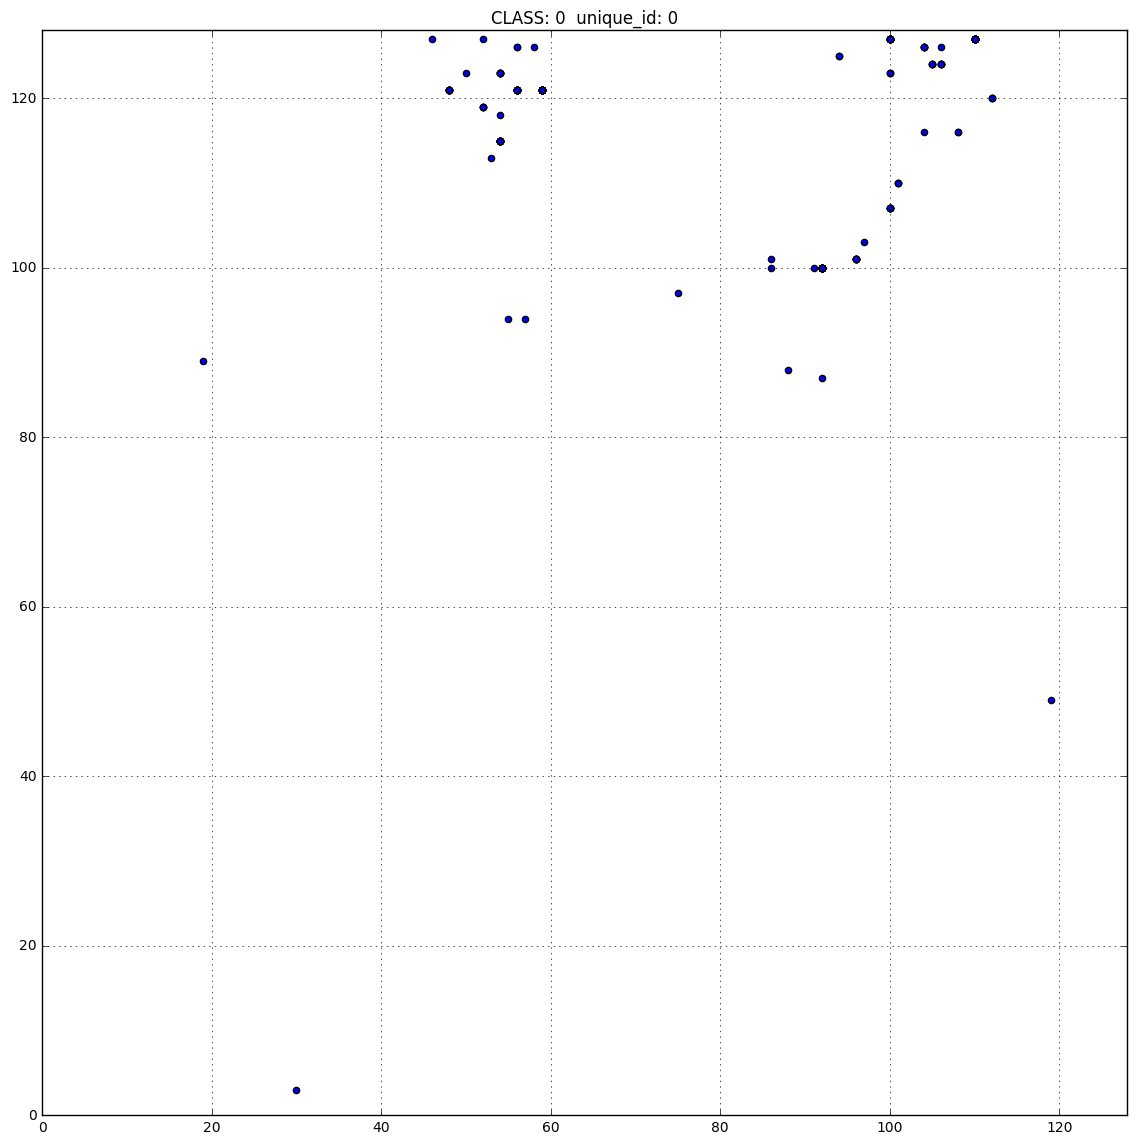

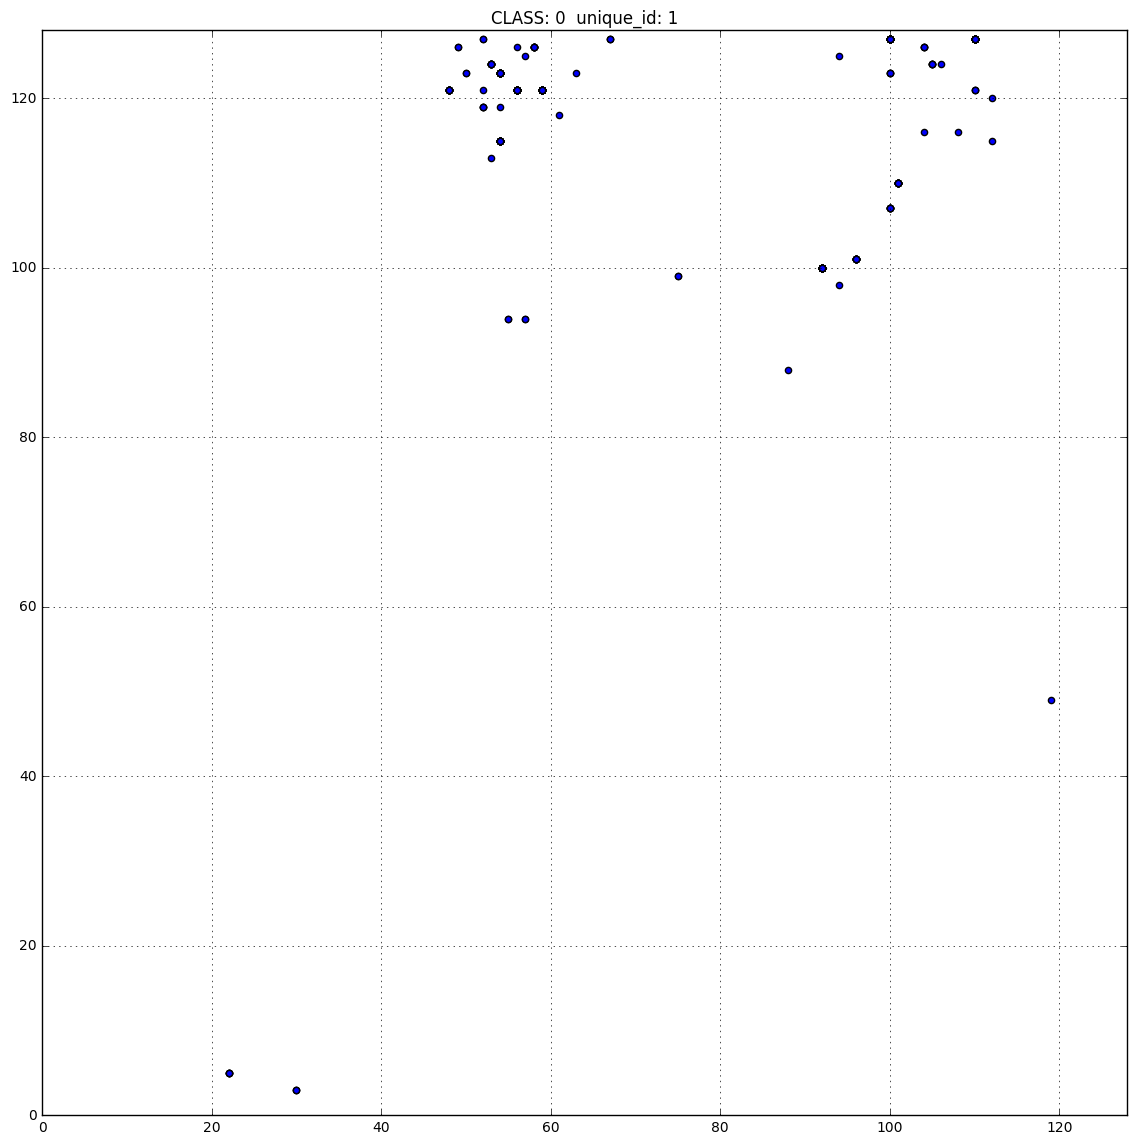

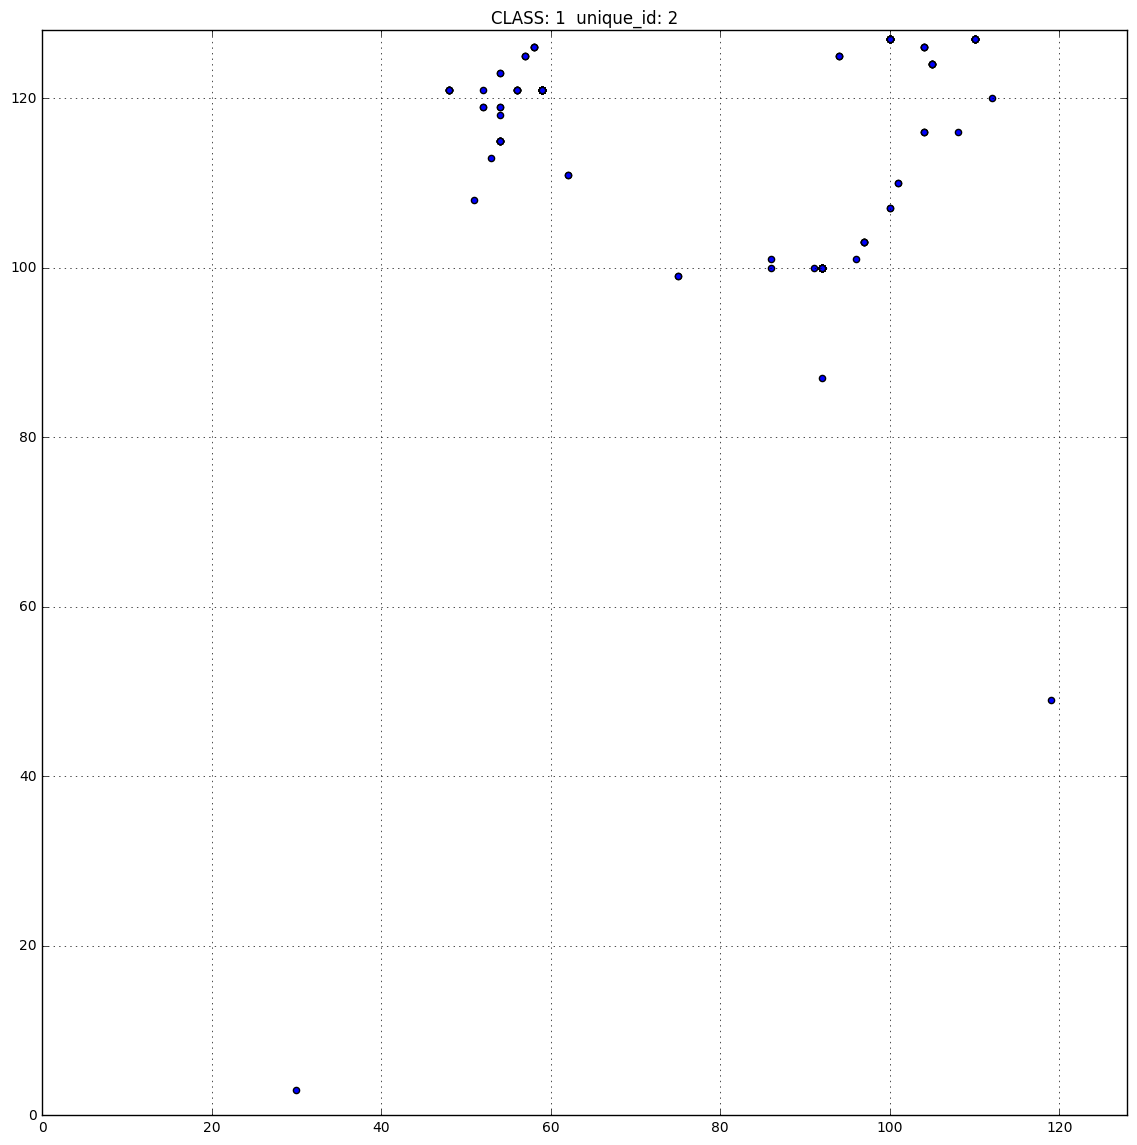

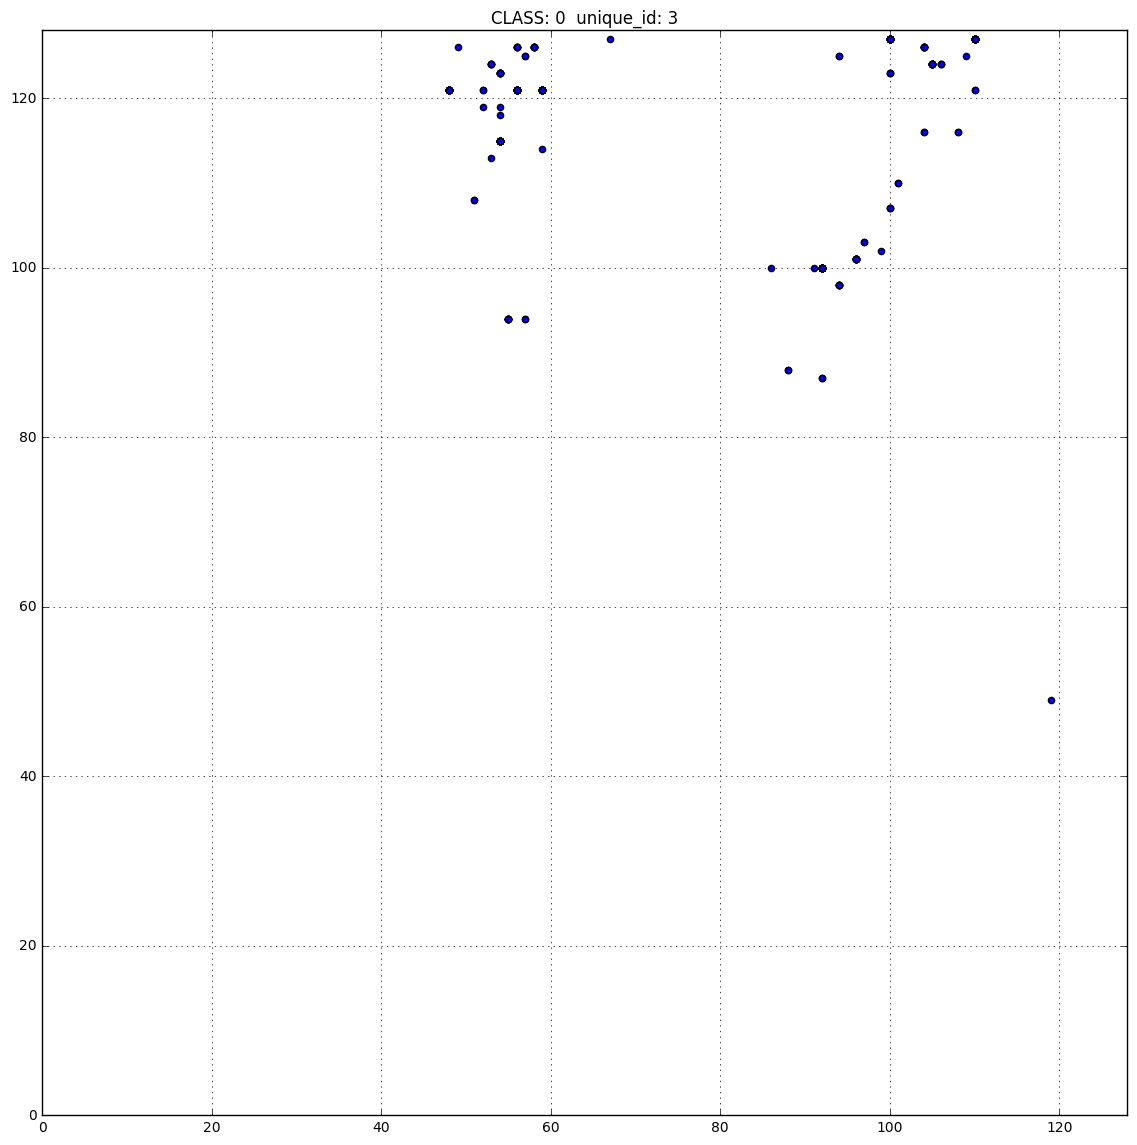

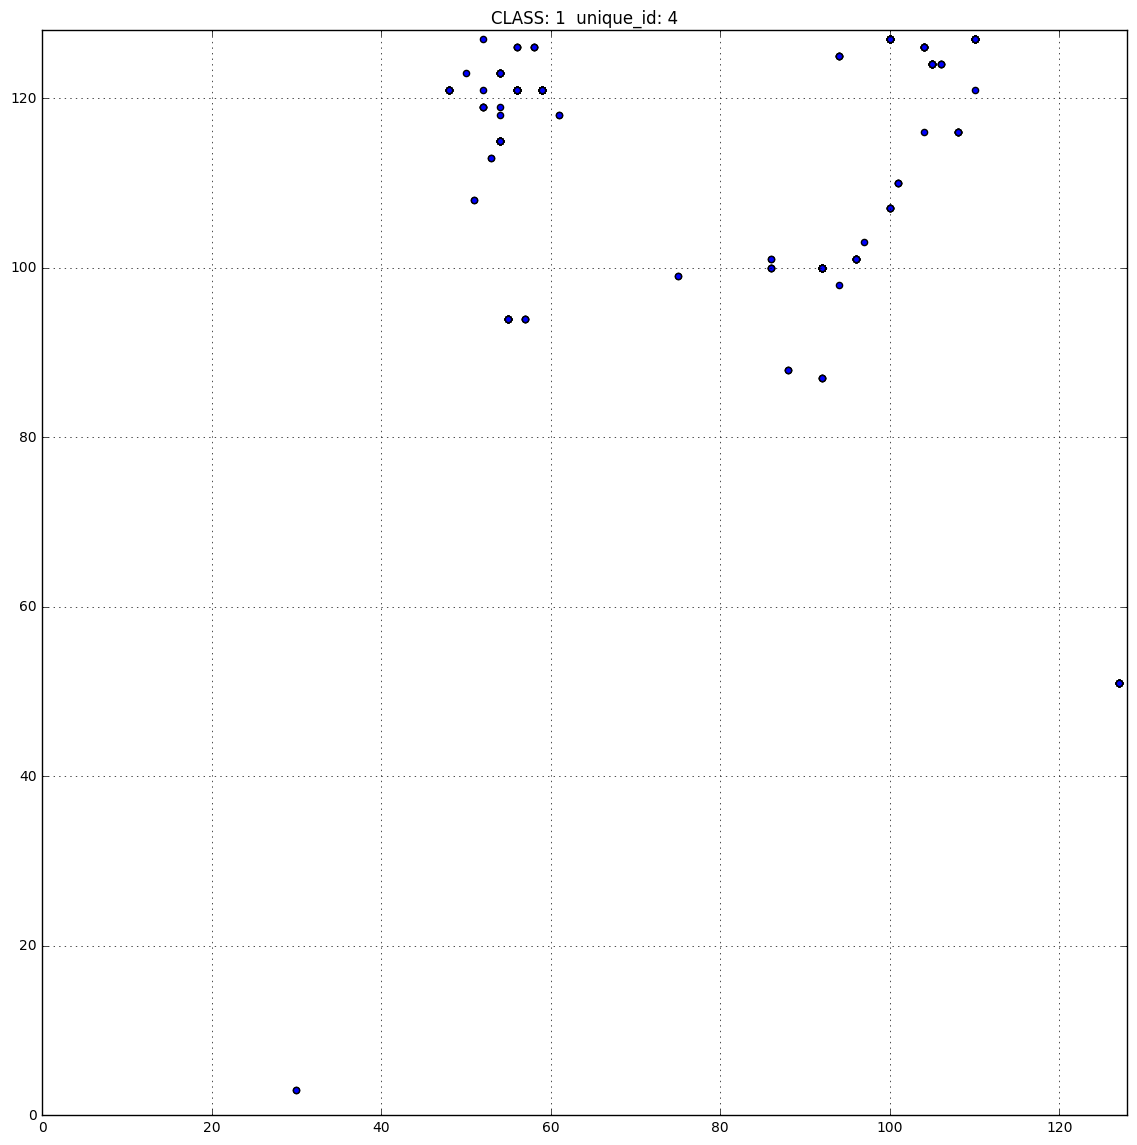

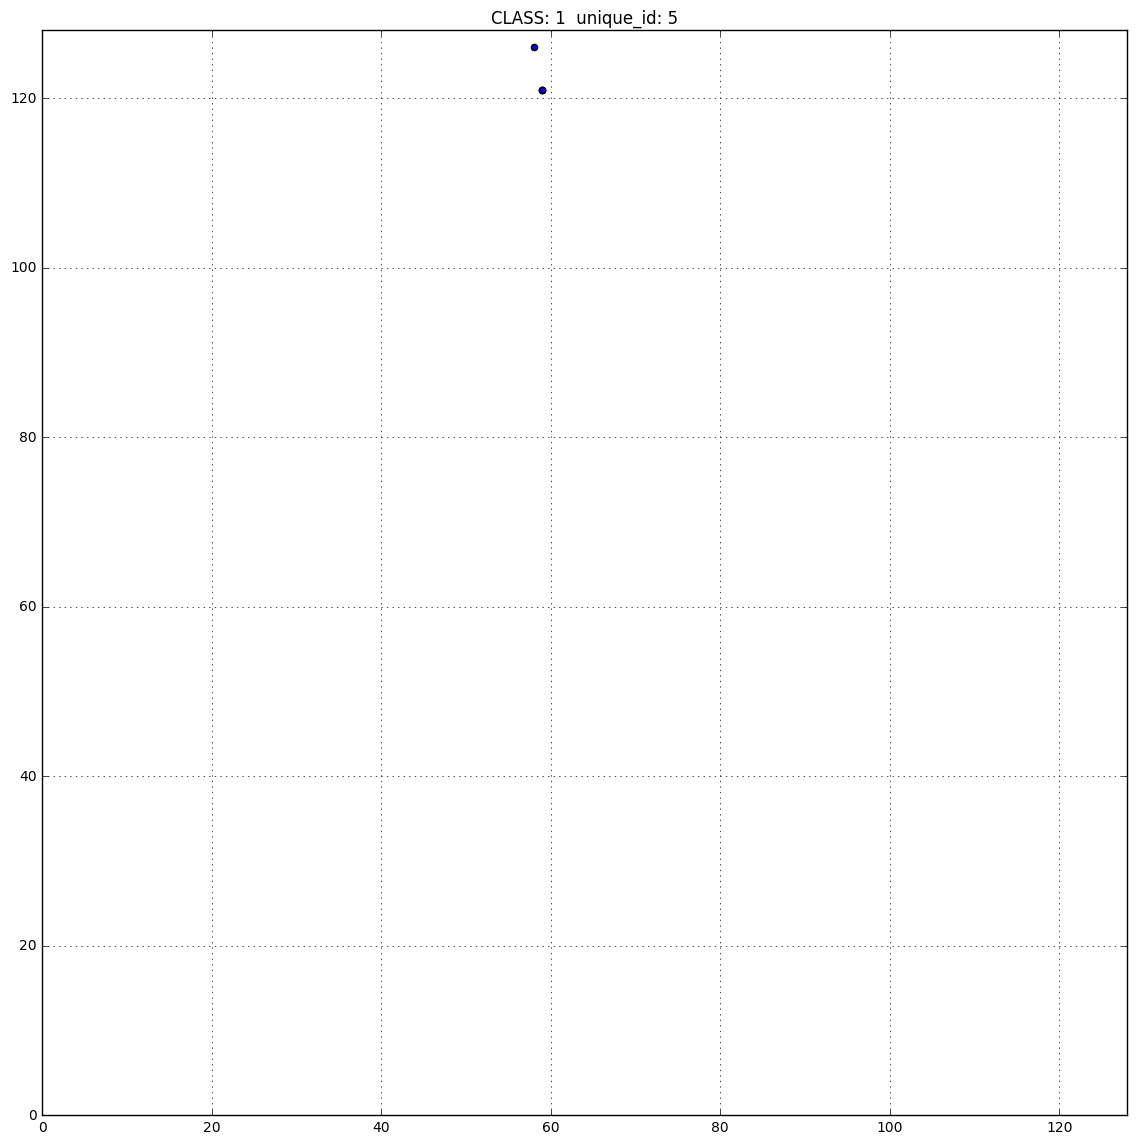

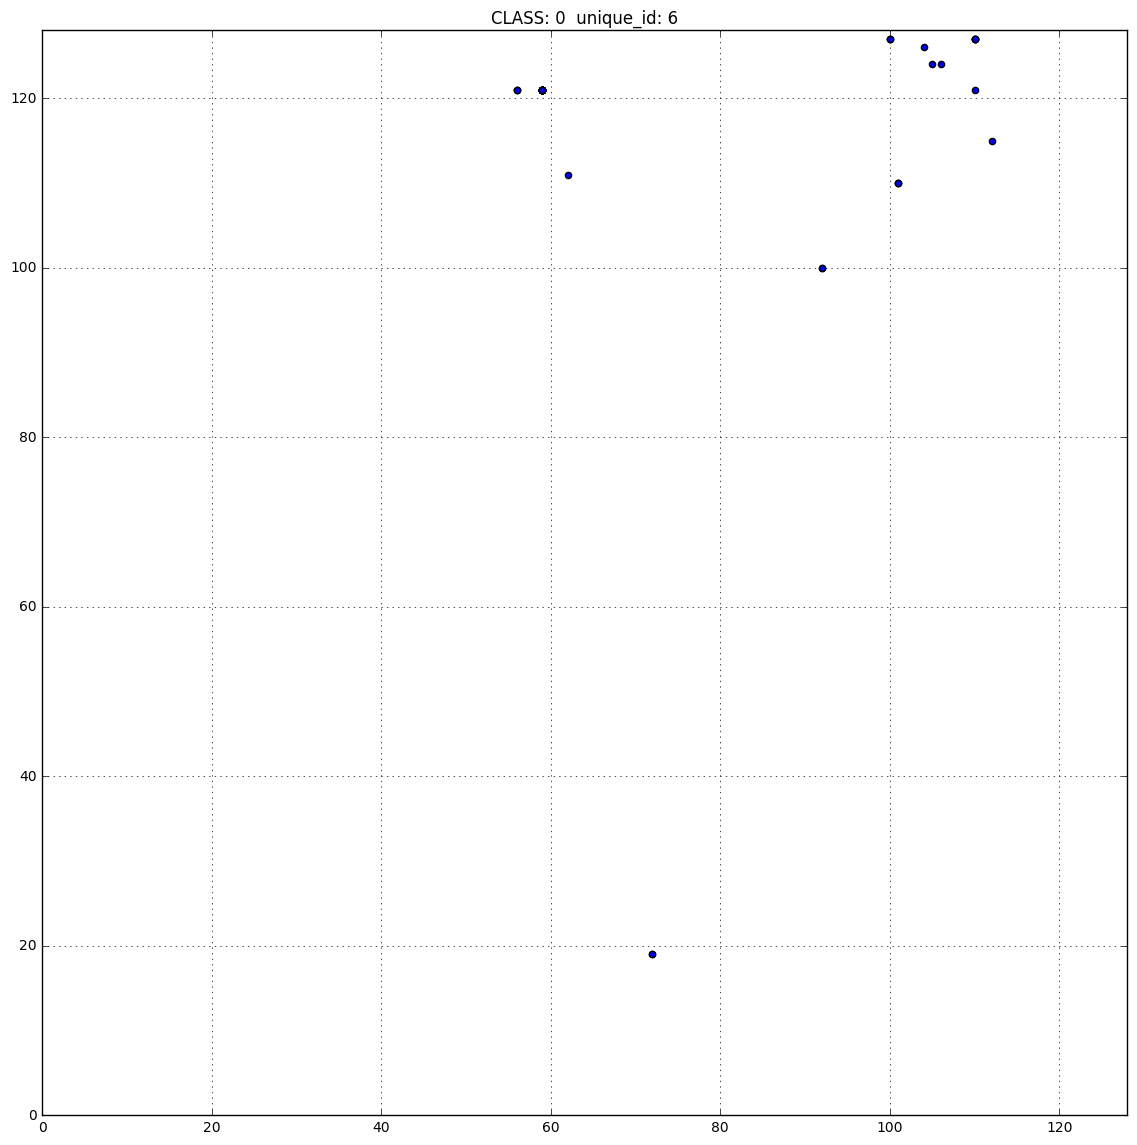

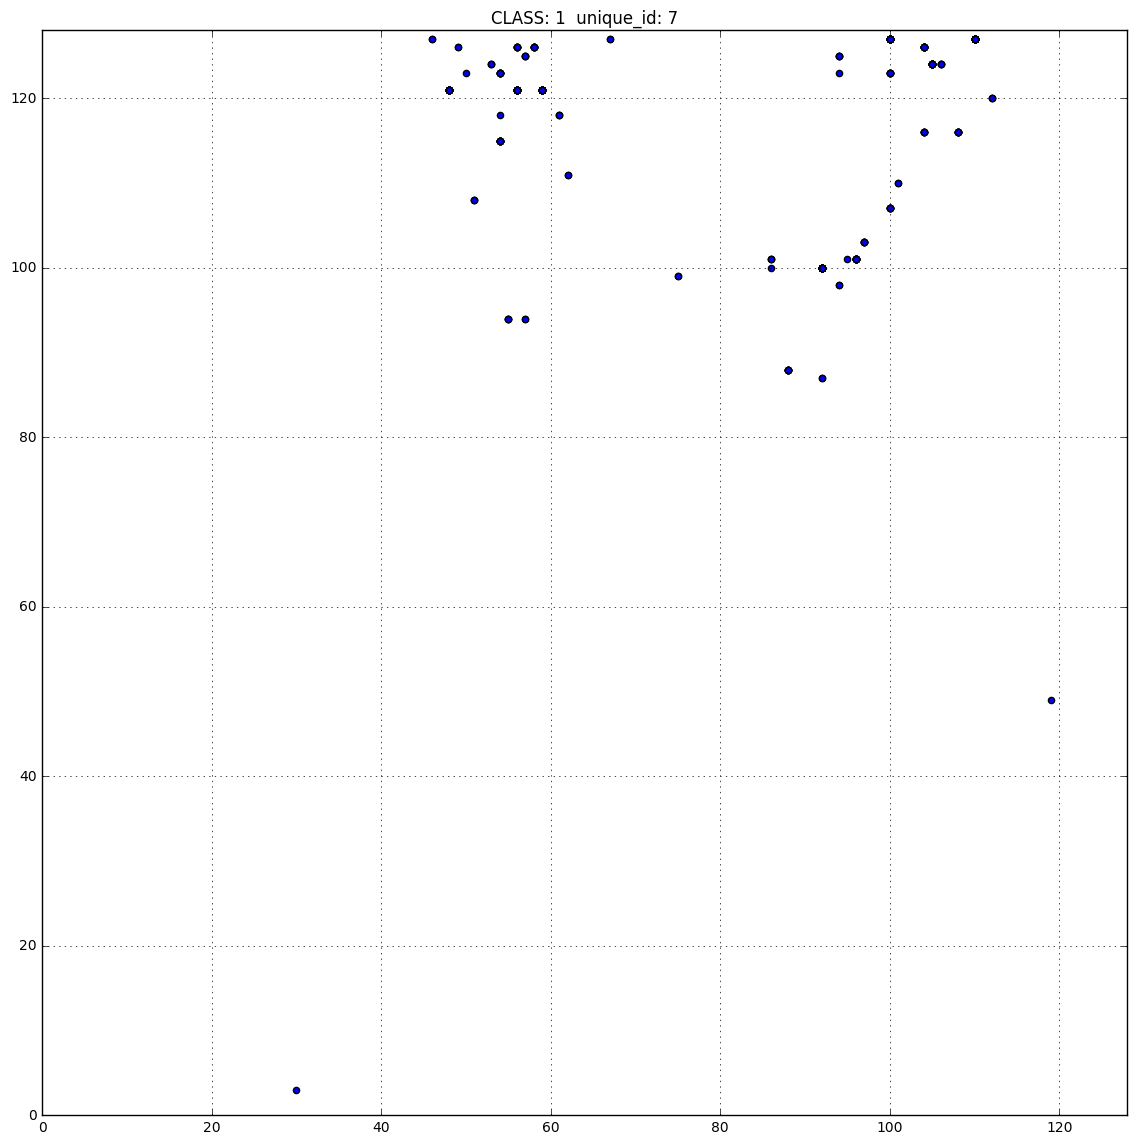

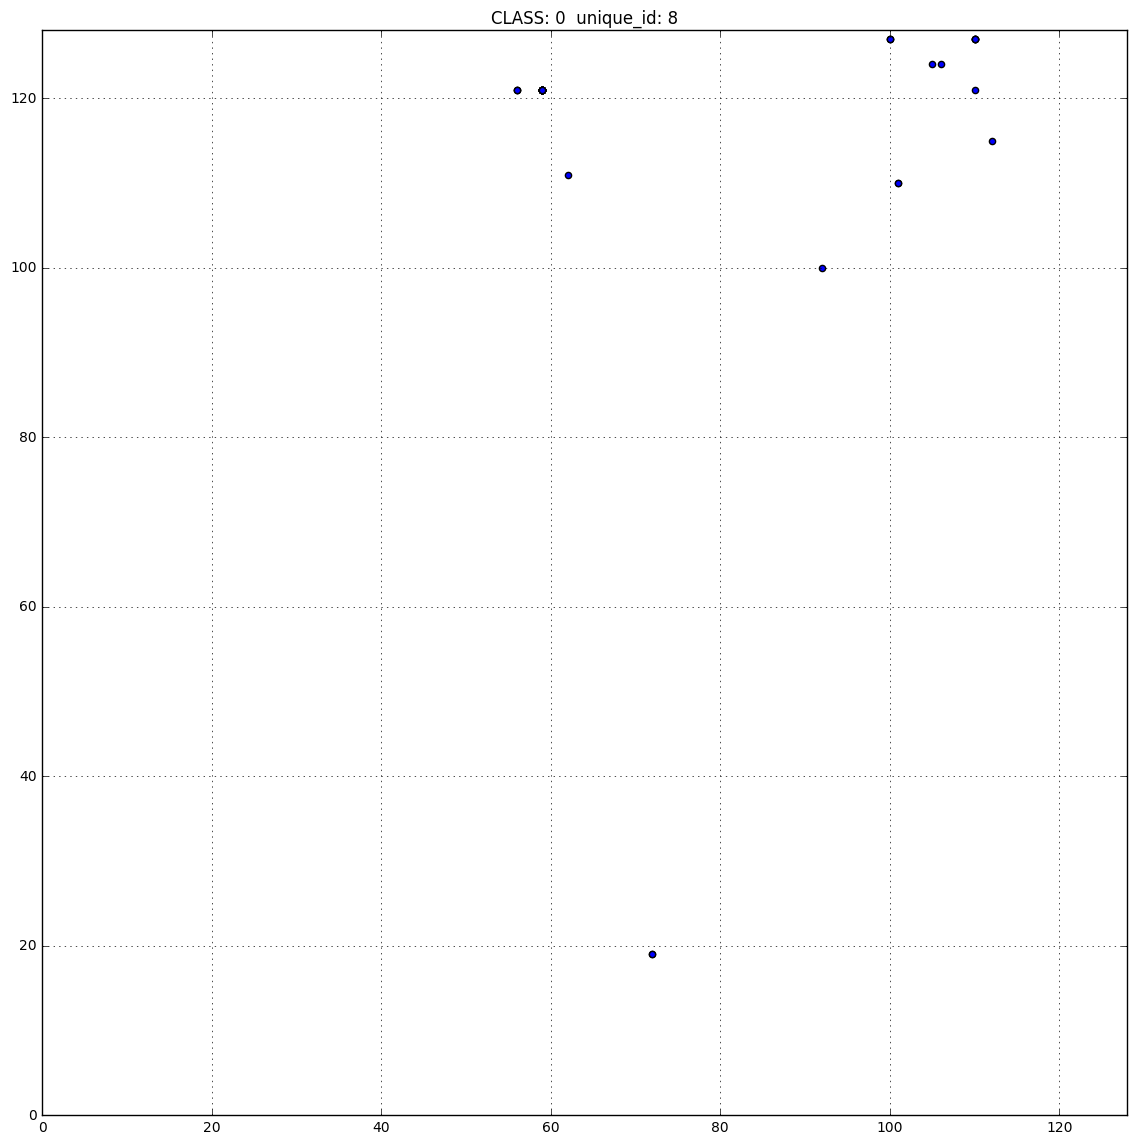

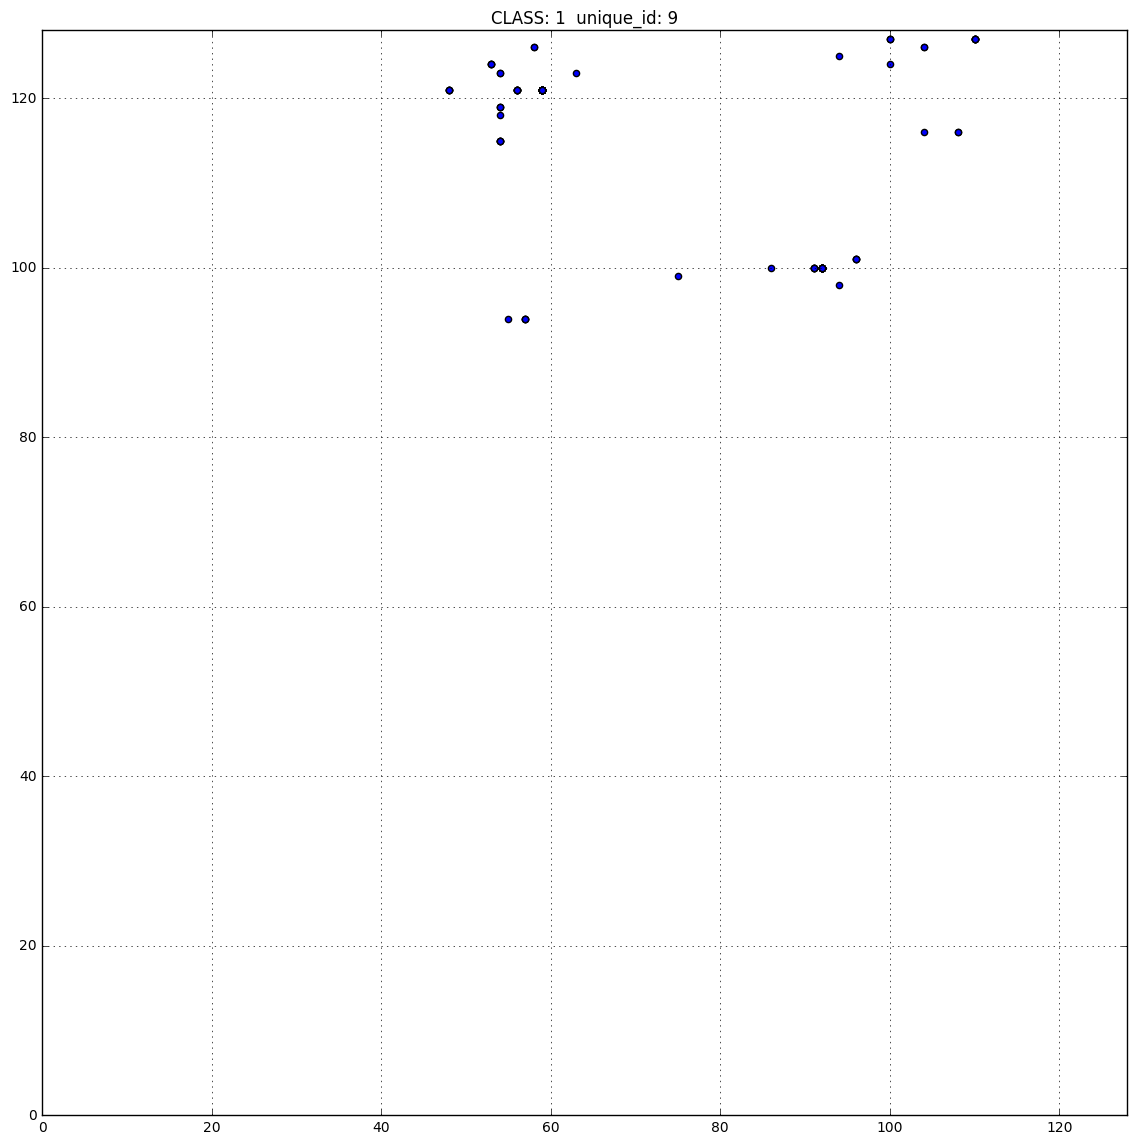

In [82]:
# didn't change anything in this cell.


import csv

def import_from_data_file(unique_id):
    with open(data_source, 'r') as source:
        csvfile = csv.reader(source)
        for line in csvfile:
            binary = line[6]
            if unique_id == line[0].strip():
                row_els = [word.lower().strip() for word in line[8].split(' ')]
                return binary, row_els
            else:
                continue
    print "URL NOT FOUND IN SOURCE FILE"
    return 0, []

import matplotlib.pyplot as plt
%matplotlib inline

data_source = 'data/medical_docs_with_id.csv'
weights_path = 'models/som_weights_3'
print "Loading weights"
som.weights = np.load("{}.npy".format(weights_path))


print "Importing from data file"
for id in range(10):
    unique_id = str(id)
    print unique_id
    binary, words = import_from_data_file(unique_id)
    arrx = []
    arry = []

    for word in words:
        try:
            x, y = som.winner(word_vectors[word])
            arrx.append(x)
            arry.append(y)
            print word, str(x), str(y)
        except:
            pass
    #print "Plotting figure"
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(arrx,arry)
    plt.axis([0,128,0,128])
    plt.grid()
    print "Saving figure to fingerprints/{}.png".format(unique_id)
    plt.title("CLASS: {}  unique_id: {}".format(str(binary), unique_id))
    plt.savefig("fingerprints/{}.png".format(unique_id))
    #plt.show()
    
print "DONE"